In [3]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

In [4]:
# Initial retrival
def get_data(path):
    generator = ImageDataGenerator(rescale=1.0/255.)
    dataset = generator.flow_from_directory(
        directory=path,
        target_size=IMG_SHAPE,
        color_mode='rgb',
        class_mode='sparse',
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )
    return dataset

In [5]:
# Image generator params
TRAIN_PATH = "covid19-resources/train"
TEST_PATH = "covid19-resources/test"
IMG_SHAPE = [224, 224]
BATCH_SIZE = 32

In [6]:
training_data = get_data(TRAIN_PATH)

Found 251 images belonging to 3 classes.


In [7]:
# Preview images
def preview_data(data):
    features = data[0][0]
    labels = data[0][1]
    fig, ax = plt.subplots(figsize=(20,20), ncols=4, nrows=4)
    for i, a in enumerate(ax.flatten()):
        a.imshow(features[i])
        a.set_title("Normal" if labels[i] == 0 else "Viral Pneumonia" if labels[i] == 1 else "Covid")
    fig.suptitle("")

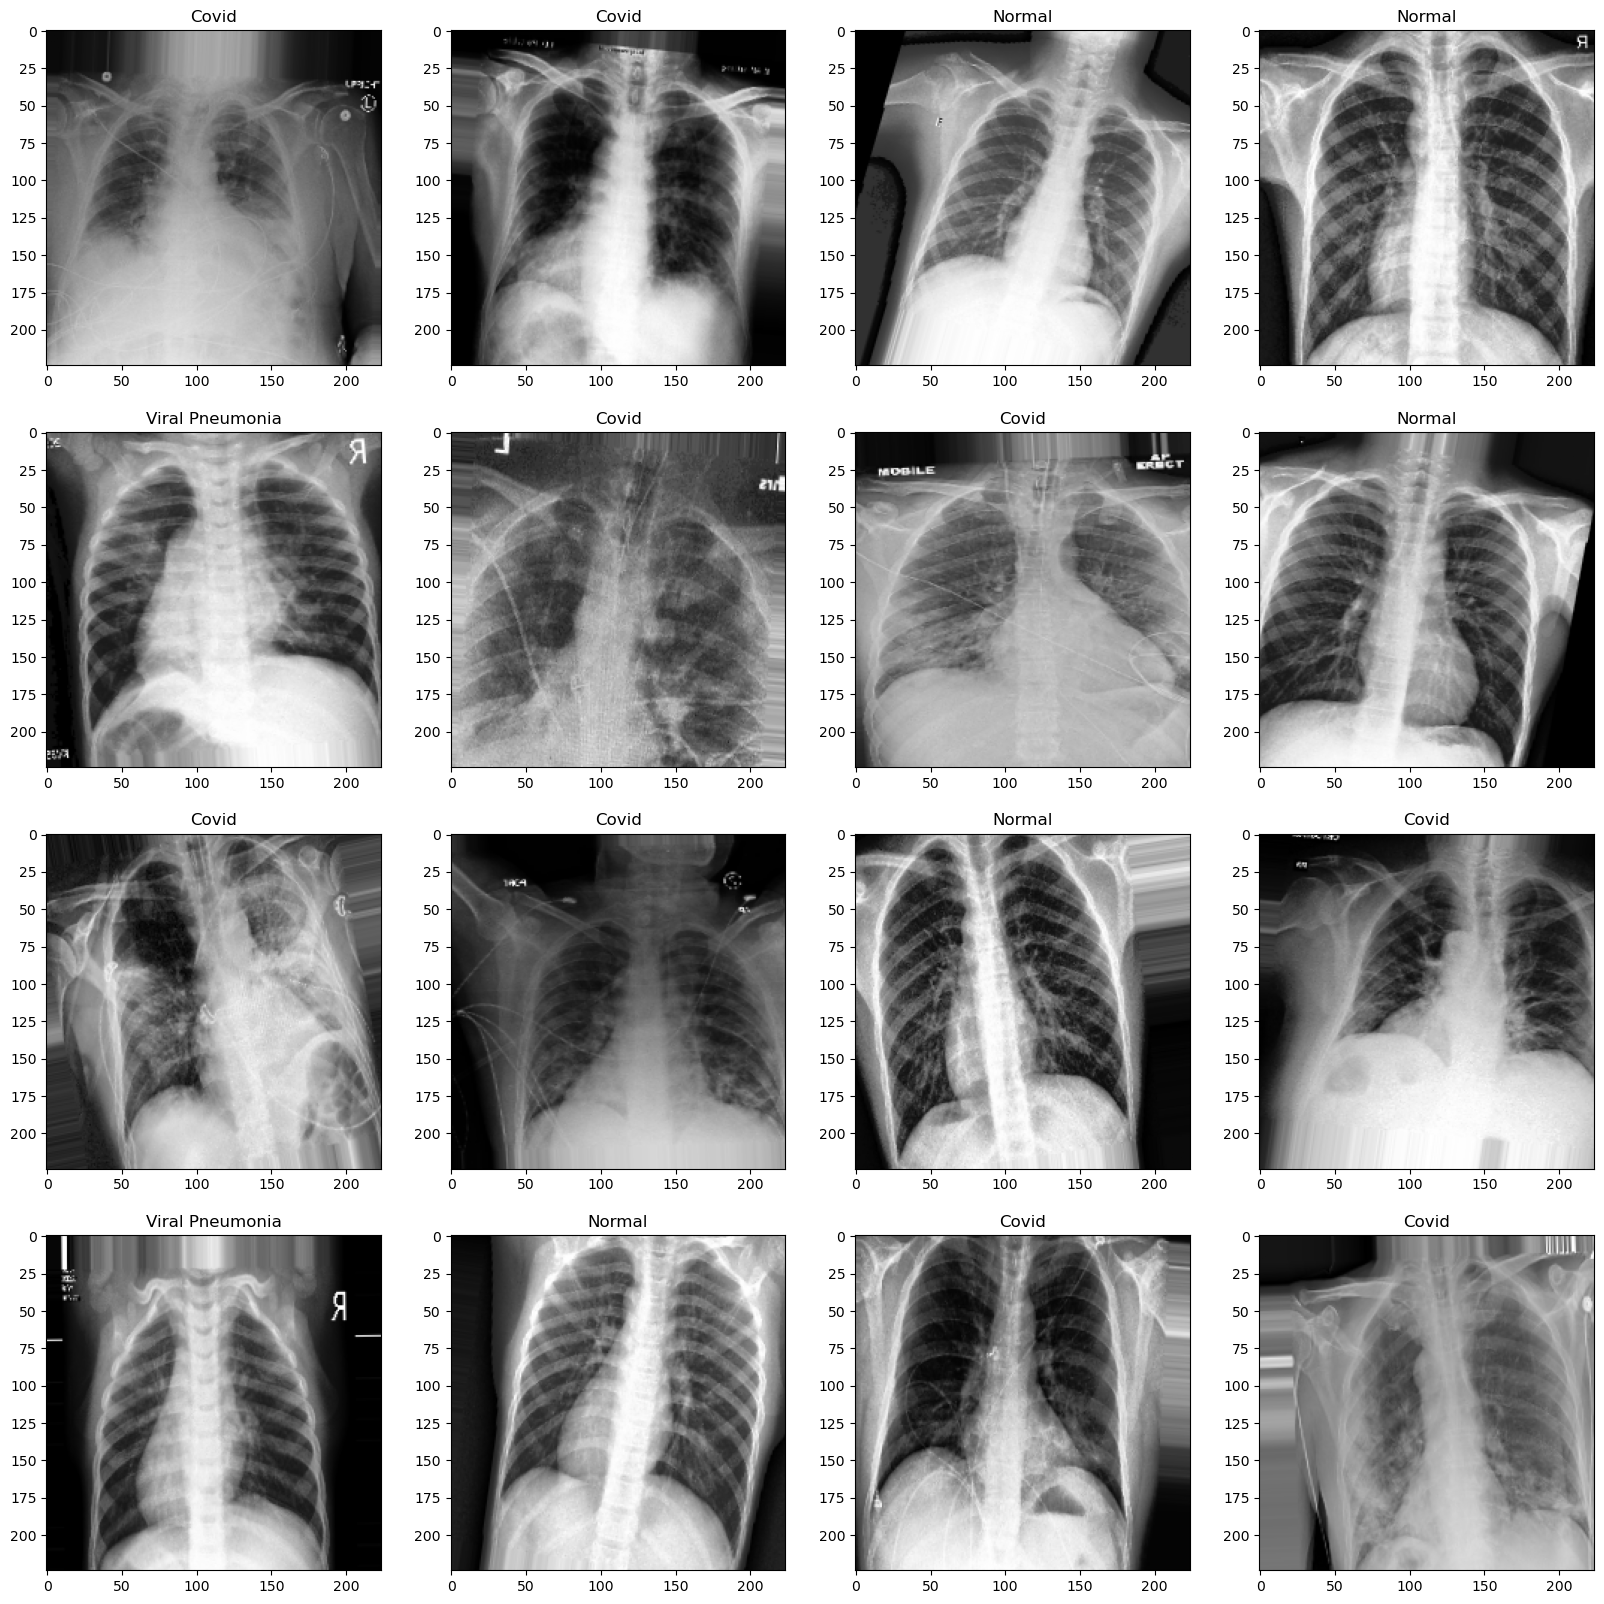

In [16]:
preview_data(training_data)

In [9]:
# Augment data to accommodate body angles, body size, etc.
def get_augmented_data(path):
    generator = ImageDataGenerator(rescale=1.0/255.,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
    )
    dataset = generator.flow_from_directory(
        directory=path,
        target_size=IMG_SHAPE,
        color_mode='rgb',
        class_mode='sparse',
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2},
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )
    return dataset

In [10]:
training_data = get_augmented_data(TRAIN_PATH)
testing_data = get_augmented_data(TEST_PATH)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


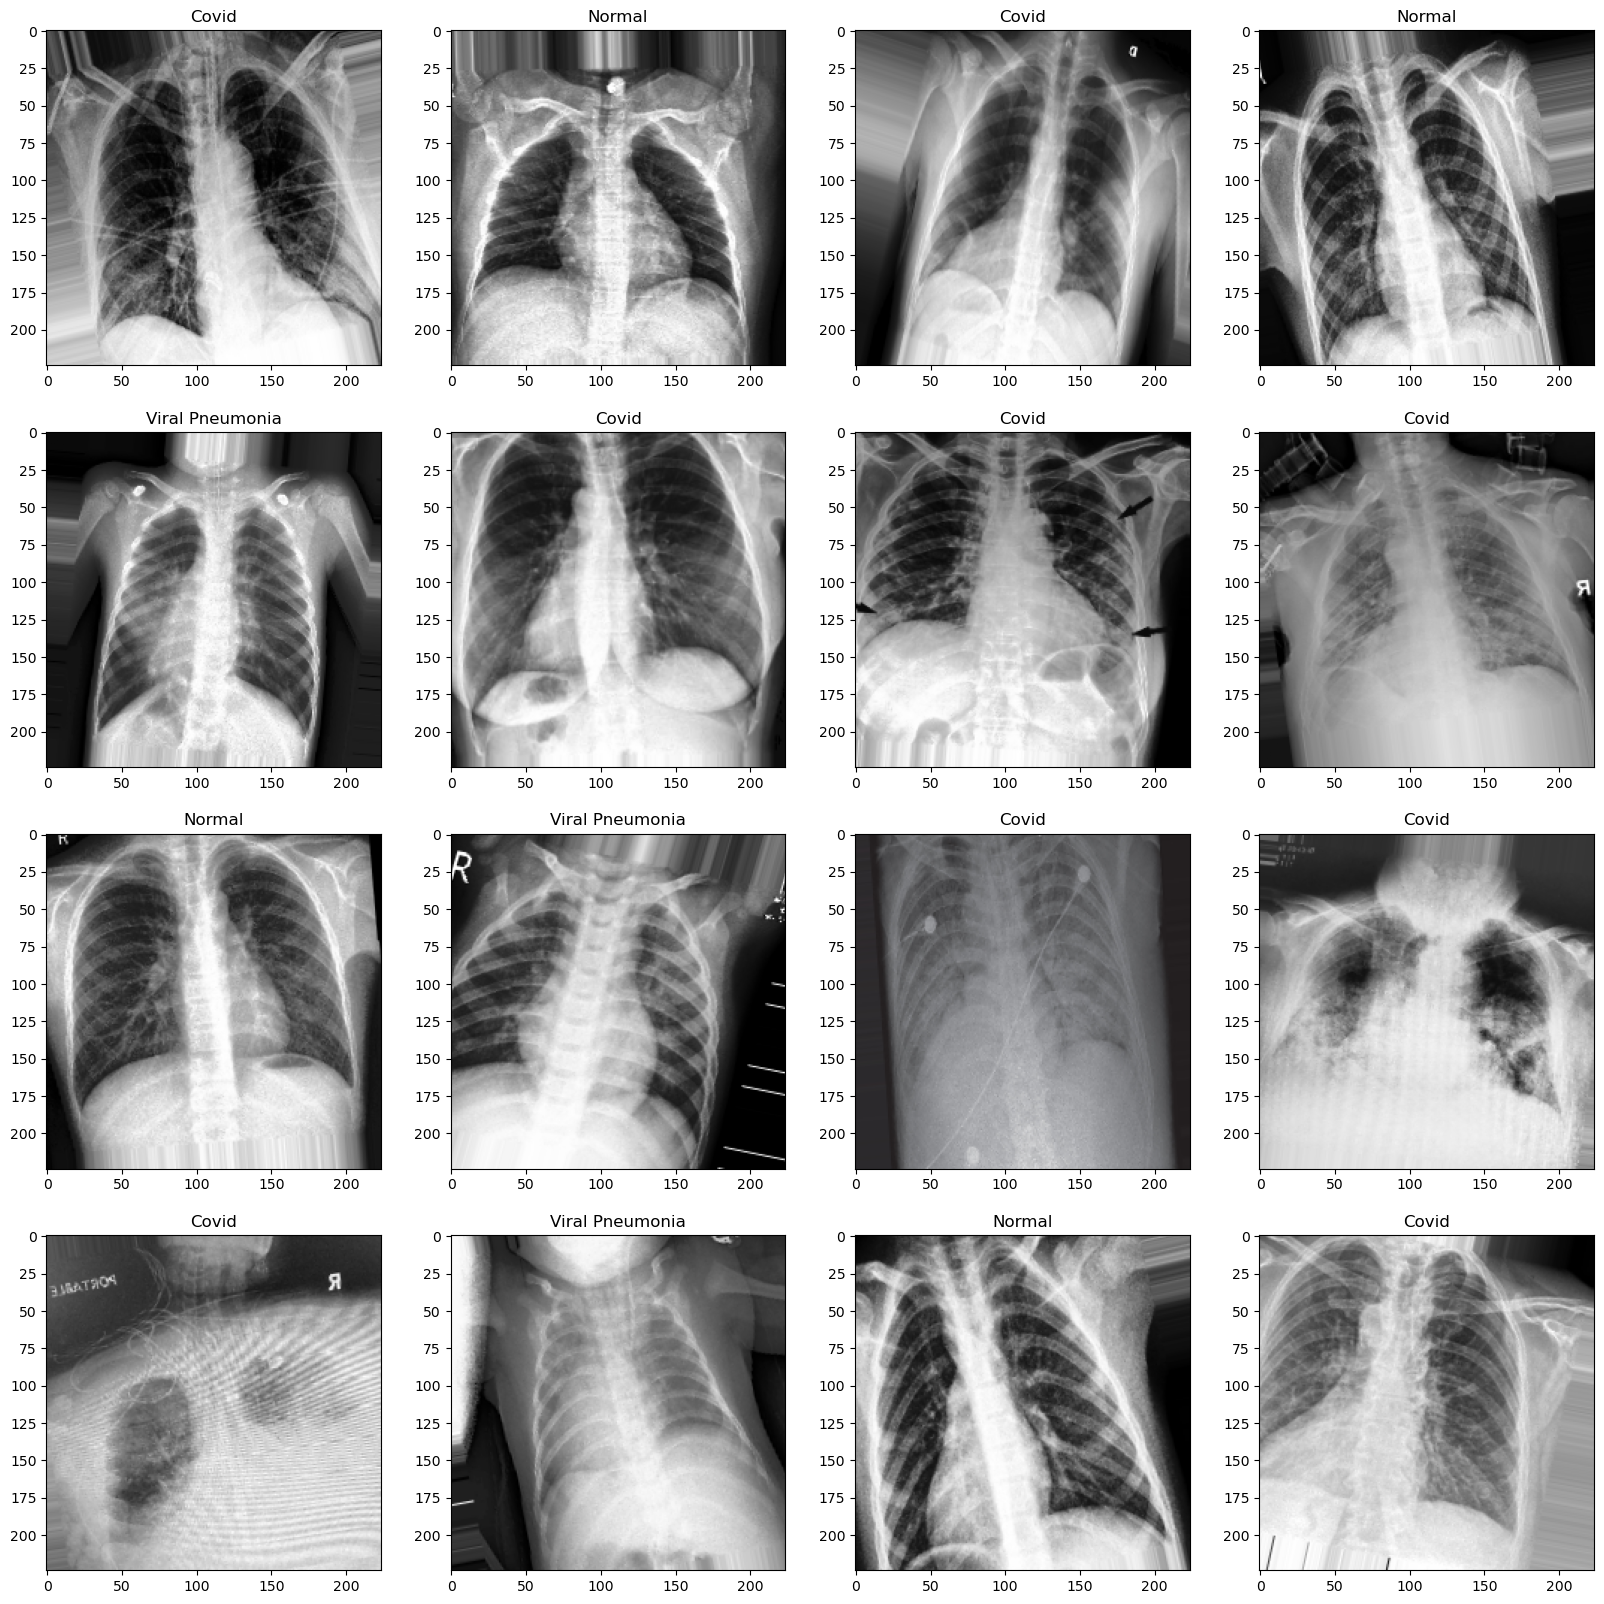

In [11]:
preview_data(training_data)

In [14]:
# Build model
class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            self.model.stop_training = True
    
def build_model_one():
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
    model.add(tf.keras.layers.Conv2D(5, 5, strides=1, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(5,5)))
    model.add(tf.keras.layers.Conv2D(7, 3, strides=1, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(3,activation="softmax"))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def fit_model(md, x_train, y_valid, e):
    callback = AccuracyCallback()
    history = md.fit(x_train, validation_data=y_valid, epochs=e, callbacks=[callback])
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    plt.legend()
    ax[1].plot(history.history['loss'], label='training_loss')
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.legend()
    return history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 5)       380       
                                                                 
 max_pooling2d (MaxPooling2  (None, 44, 44, 5)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 7)         322       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 7)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3087)              0         
                                                                 
 dense (Dense)               (None, 3)                 9

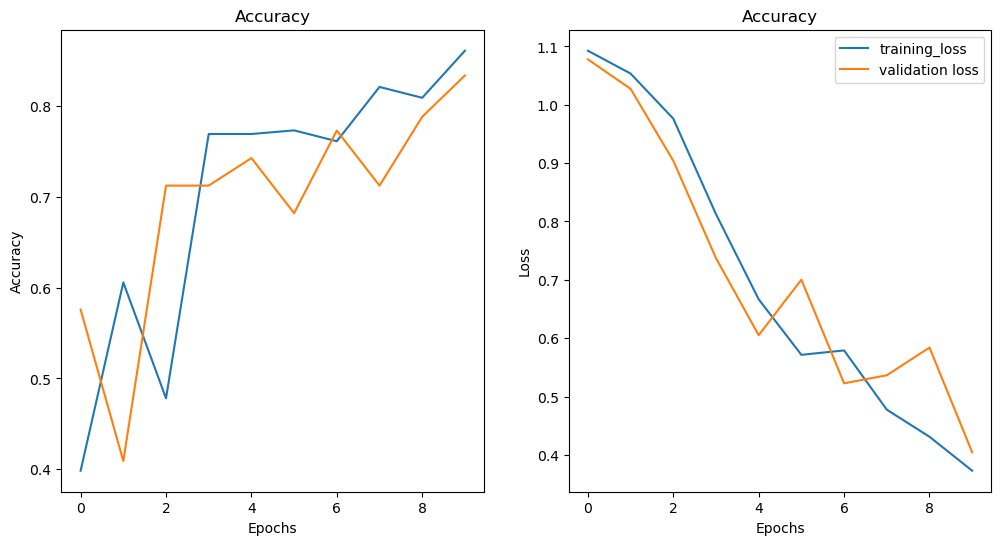

In [15]:
# Model testing
model = build_model_one()
model.summary()

fit_model(model, training_data, testing_data, e=10)